In [79]:
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import multilabel_confusion_matrix, confusion_matrix, ConfusionMatrixDisplay
import pandas as pd
from models_torch import get_model, model_dict
import optuna
import os
import json
from image_transforms import get_transforms
from data_loading import DfDataset
from pattern.metrics.multi_label_metrics import multi_label_f_beta, multi_label_precision, multi_label_recal, multi_label_accuracy, multi_label_confusion_matrix

In [80]:
model_key = 'resnet18'
#set the operating point for the model
best_threshold = 0.24
#set torch device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [81]:
#get the model inference transforms
transform_config = model_dict[model_key]['transforms_config']
transform_type = 'standard'
inference_transforms = get_transforms(transform_name=transform_type, transforms_config=transform_config)

In [82]:
#load the dataset the model was trained on
with open('datasets/2024-01-31_11-09-02/dataset_config.json', 'r') as f:
    dataset_config = json.load(f)
data_path_col = dataset_config['path_to_img_coulumn']
label_cols = dataset_config['label_names']
all_train_data_path = 'datasets/2024-01-31_11-09-02/All_train.csv'
all_train_data = pd.read_csv(all_train_data_path)
all_train_dataset = DfDataset(all_train_data, transform=inference_transforms, data_path_col=data_path_col, label_cols=label_cols)
all_train_loader = DataLoader(all_train_dataset, batch_size=32, shuffle=False)

In [83]:
#load the dataset which the model will be evaluated on
all_test_data_path = 'datasets/2024-01-31_11-09-02/All_test.csv'
all_test_data = pd.read_csv(all_test_data_path)
all_test_dataset = DfDataset(all_test_data, transform=inference_transforms, data_path_col=data_path_col, label_cols=label_cols)
all_test_loader = DataLoader(all_test_dataset, batch_size=32, shuffle=False)

In [84]:
#all validation data
all_val_data_path = 'datasets/2024-01-31_11-09-02/All_validation.csv'
all_val_data = pd.read_csv(all_val_data_path)
all_val_dataset = DfDataset(all_val_data, transform=inference_transforms, data_path_col=data_path_col, label_cols=label_cols)
all_validation_loader = DataLoader(all_val_dataset, batch_size=32, shuffle=False)

In [85]:
#initialize the model
model_config_folder_path = 'models/resnet18/6858584f-8c9e-483b-ac21-a01f7491e781/'
best_model_weights_path = f'{model_config_folder_path}best_model.pt'
n_classes = len(all_train_dataset.classes)
model = get_model(model_name=model_key, num_classes=n_classes, pretrained=False)
model.load_state_dict(torch.load(best_model_weights_path))
model.eval()


c:\Users\elyes\miniconda3\envs\ird_deep_learning\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\elyes\miniconda3\envs\ird_deep_learning\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [86]:
#define the objective function to find the best threshold
def objective(trial):
    #get the threshold to use for the model
    threshold = trial.suggest_float('threshold', 0.0, 1.0, step=0.01)
    #do the predictions
    y_true = []
    y_pred = []
    model.to(device)
    model.eval()
    with torch.no_grad():
        for inputs, labels in all_validation_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            y_true.append(labels.detach().clone())
            y_pred.append(outputs.detach().clone())
    y_true = torch.cat(y_true, dim=0).cpu()
    y_pred = torch.cat(y_pred, dim=0).cpu()
    #calculate the f1 score
    f1_score = multi_label_f_beta(y_true, y_pred, beta=1.0, averaging_type='macro', threshold=threshold)
    return f1_score

In [87]:
#find the best threshold
optuna.logging.set_verbosity(optuna.logging.WARNING)
if not best_threshold:
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=100, show_progress_bar=True)
    best_threshold = study.best_params['threshold']
    #save the best threshold in model folder as a json file
    with open(f'{model_config_folder_path}best_threshold.json', 'w') as f:
        json.dump({'best_threshold': best_threshold}, f)
    print(f'Best threshold: {best_threshold}')
    #visualize the optimization history
    optuna.visualization.plot_optimization_history(study).show()

  0%|          | 0/100 [00:00<?, ?it/s]c:\Users\elyes\IRD-DeepLearning\pattern\metrics\multi_label_metrics.py:137: RuntimeWarning: invalid value encountered in divide
  precision = true_positives / (true_positives + false_positives)
Best trial: 0. Best value: 0.739898:   2%|▏         | 2/100 [00:14<11:17,  6.91s/it]c:\Users\elyes\IRD-DeepLearning\pattern\metrics\multi_label_metrics.py:137: RuntimeWarning: invalid value encountered in divide
  precision = true_positives / (true_positives + false_positives)
Best trial: 2. Best value: 0.753244:   3%|▎         | 3/100 [00:20<10:44,  6.64s/it]c:\Users\elyes\IRD-DeepLearning\pattern\metrics\multi_label_metrics.py:137: RuntimeWarning: invalid value encountered in divide
  precision = true_positives / (true_positives + false_positives)
Best trial: 3. Best value: 0.781803:   5%|▌         | 5/100 [00:33<10:14,  6.47s/it]c:\Users\elyes\IRD-DeepLearning\pattern\metrics\multi_label_metrics.py:137: RuntimeWarning: invalid value encountered in divide

Best threshold: 0.24


In [93]:
#visualize the slices of study
optuna.visualization.plot_slice(study).show()

In [88]:
#execute the model on the test set
y_true = []
y_pred = []
model.to(device)
model.eval()
with torch.no_grad():
    for inputs, labels in all_test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        y_true.append(labels.detach().clone())
        y_pred.append(outputs.detach().clone())
y_true = torch.cat(y_true, dim=0).cpu()
y_pred = torch.cat(y_pred, dim=0).cpu()

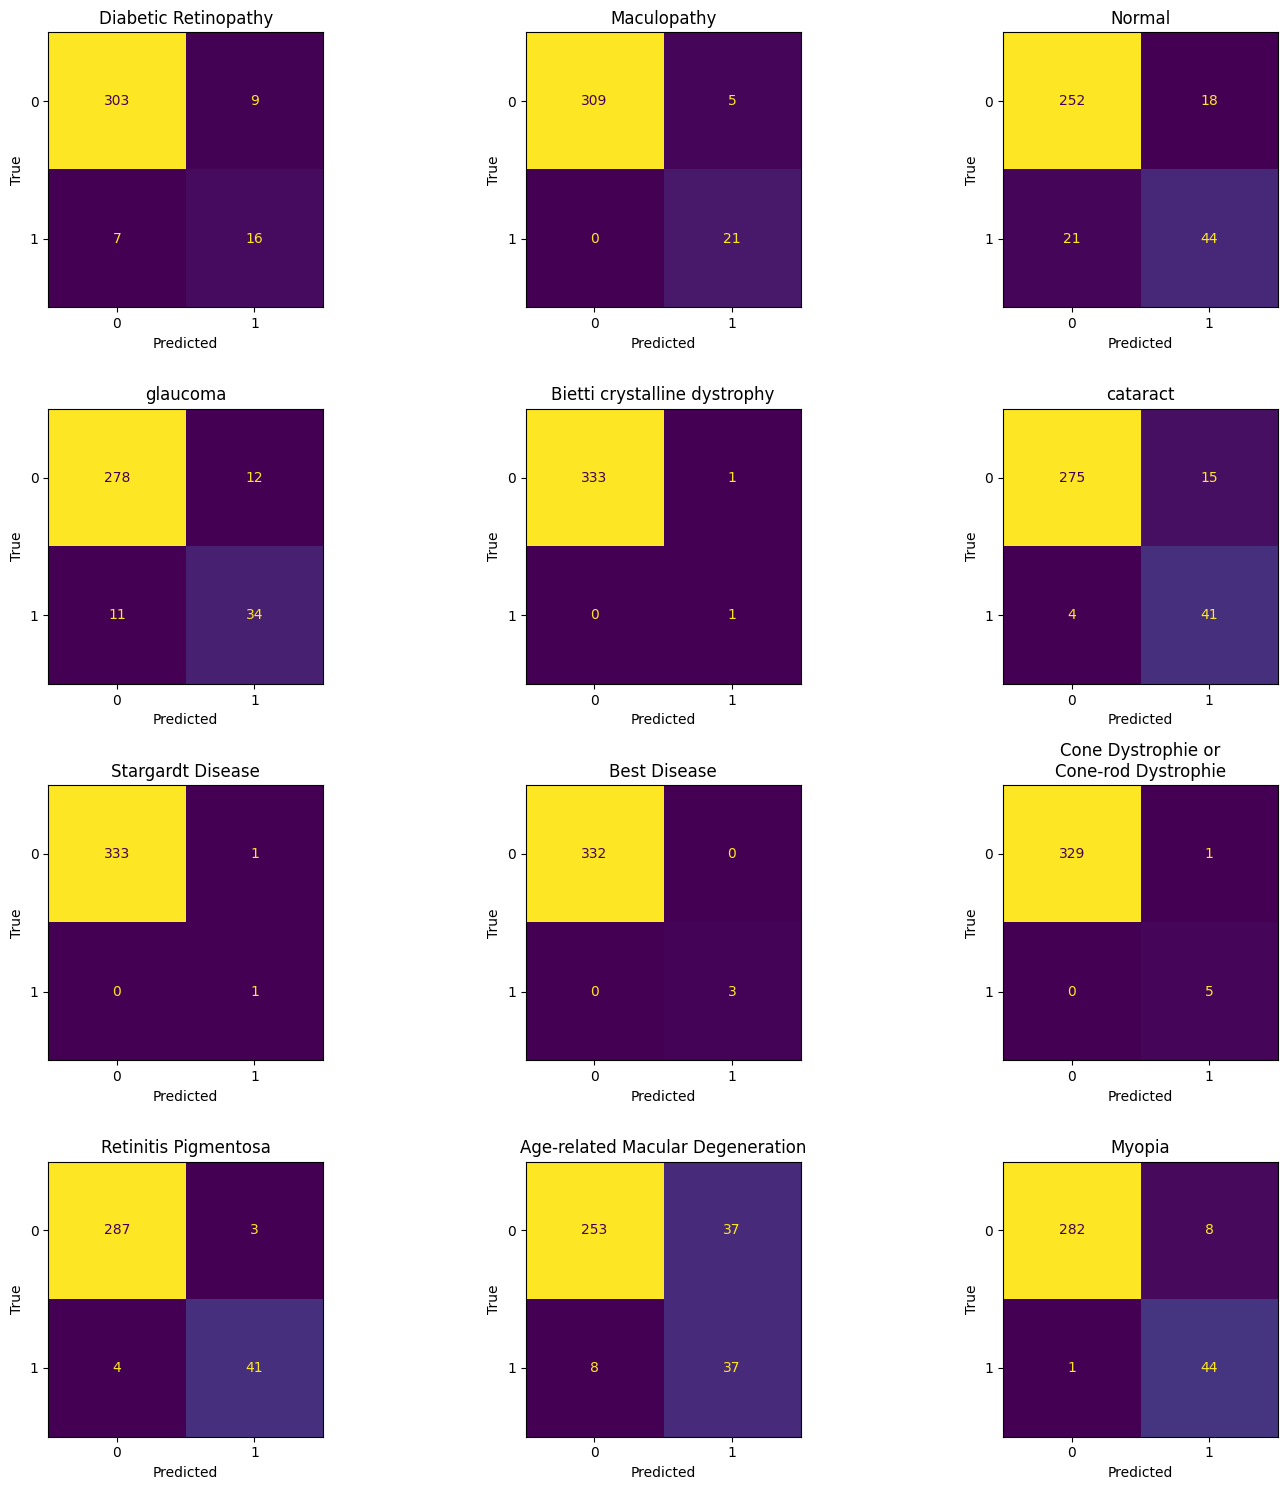

In [89]:
y_pred_cm = torch.sigmoid(y_pred) >best_threshold
#calculate the confusion matrices on the test set
confusion_matrices = multilabel_confusion_matrix(y_true, y_pred_cm)
#plot the confusion matrices, one for each class, 3 per row
n_cols = 3
n_rows = int(np.ceil(len(all_train_dataset.classes) / n_cols))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 15))
axes = axes.flatten()
for i, ax in enumerate(axes):
    #use the confusion matrix to plot the confusion matrix
    cm = confusion_matrices[i]
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    #turn off color bar

    disp.plot(ax=ax, colorbar=False,values_format='d')
    title = all_train_dataset.classes[i]
    #split the title into multiple lines if it is too long
    if title.count(' ') > 2:
        #split every 3rd space
        title = title.split(' ')
        title = [' '.join(title[i:i+3]) for i in range(0, len(title), 3)]
        title = '\n'.join(title)
    ax.set_title(title)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')
plt.tight_layout()
plt.show()

In [90]:
print(y_pred.size())
print(torch.sigmoid(y_pred[0,1]))

torch.Size([335, 12])
tensor(0.9442)


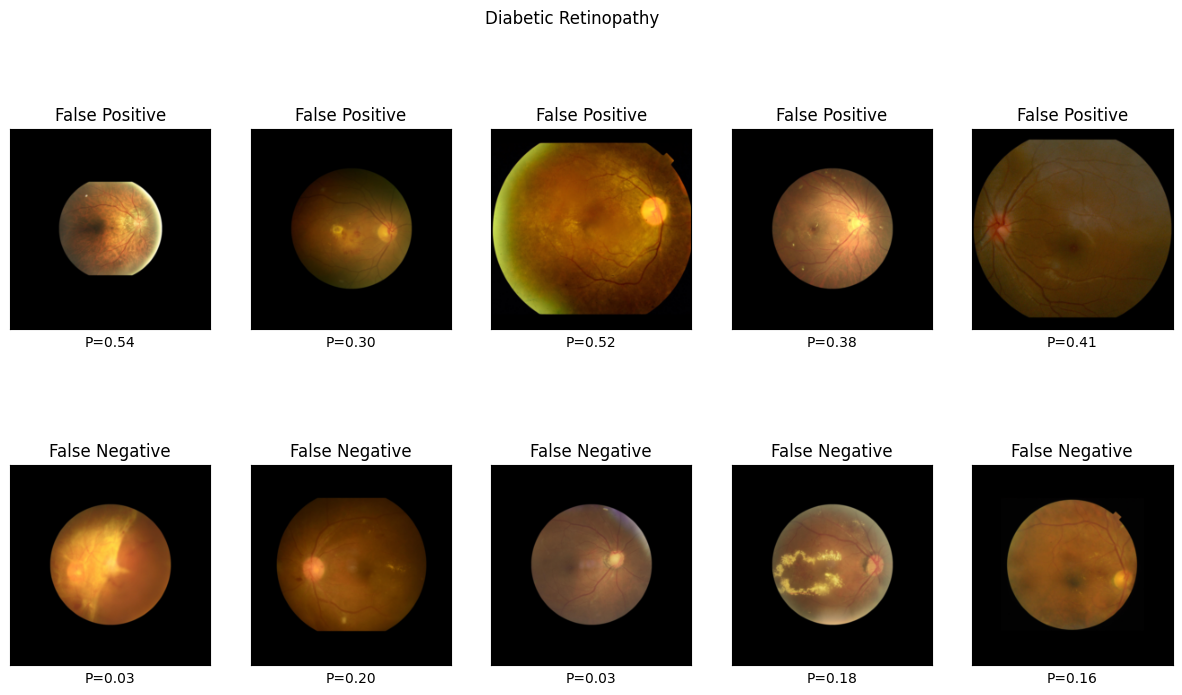

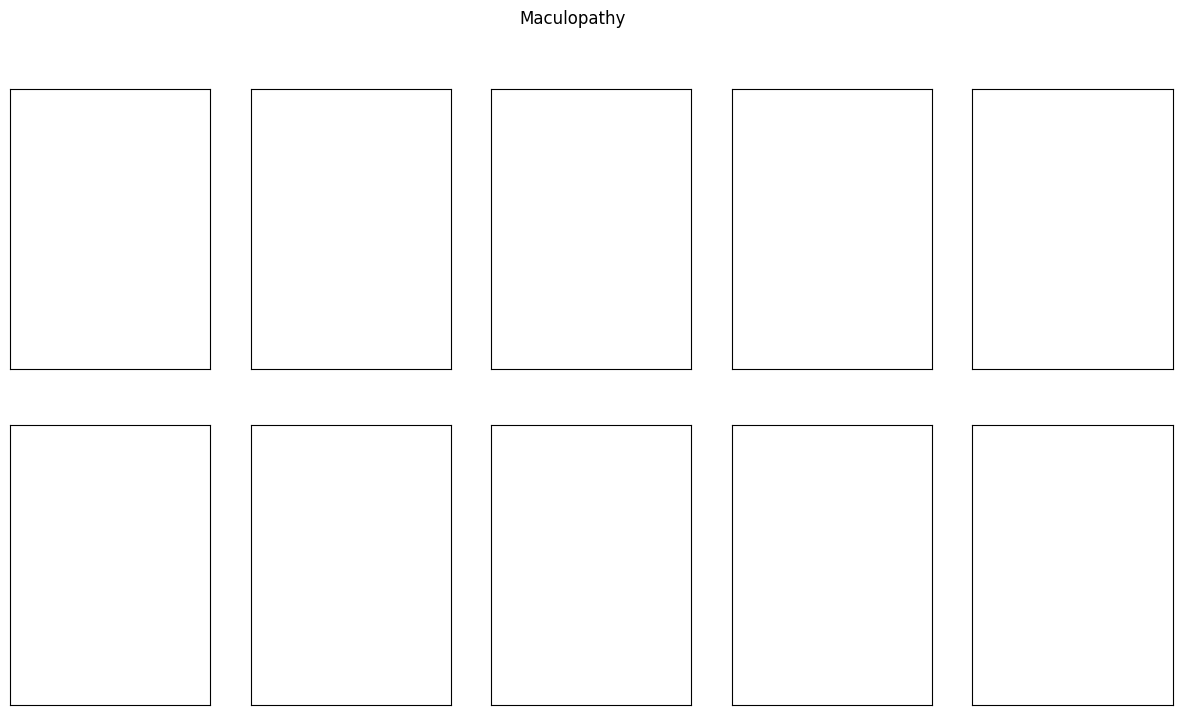

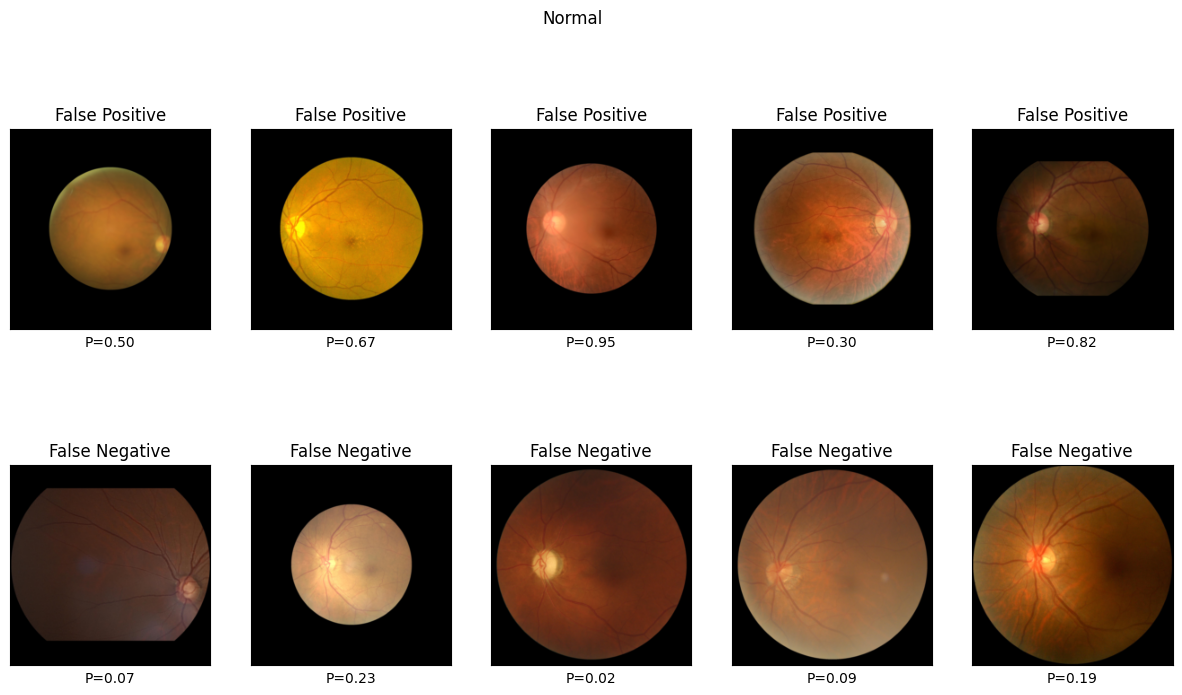

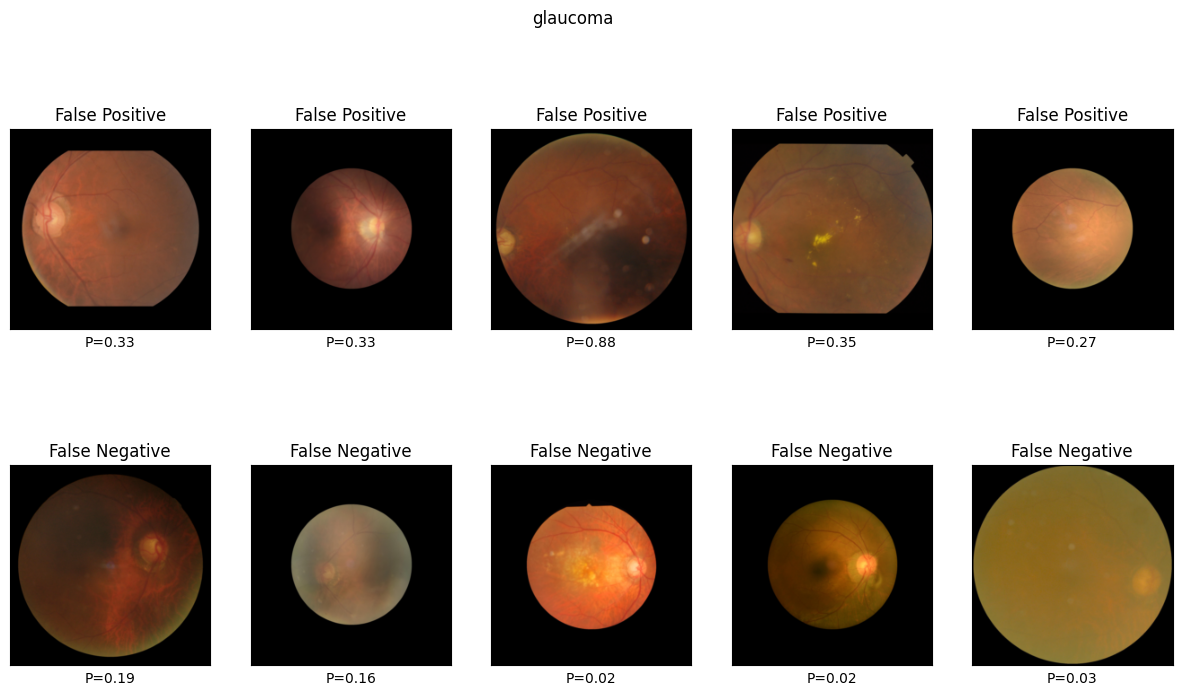

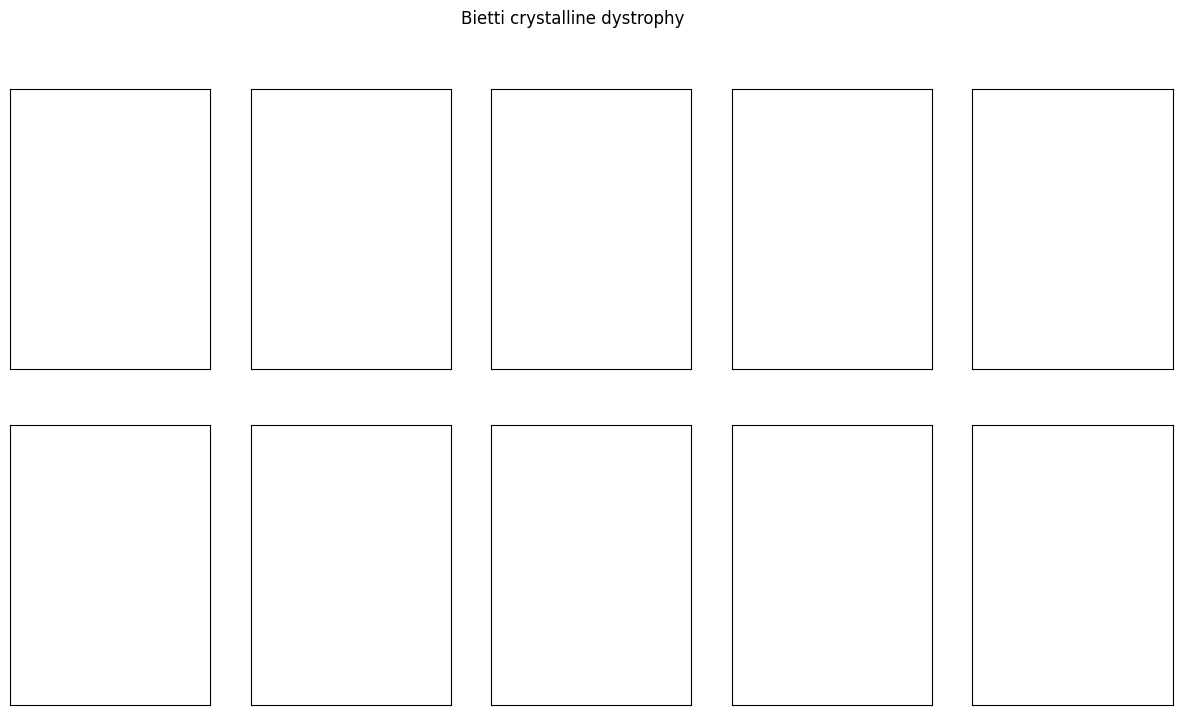

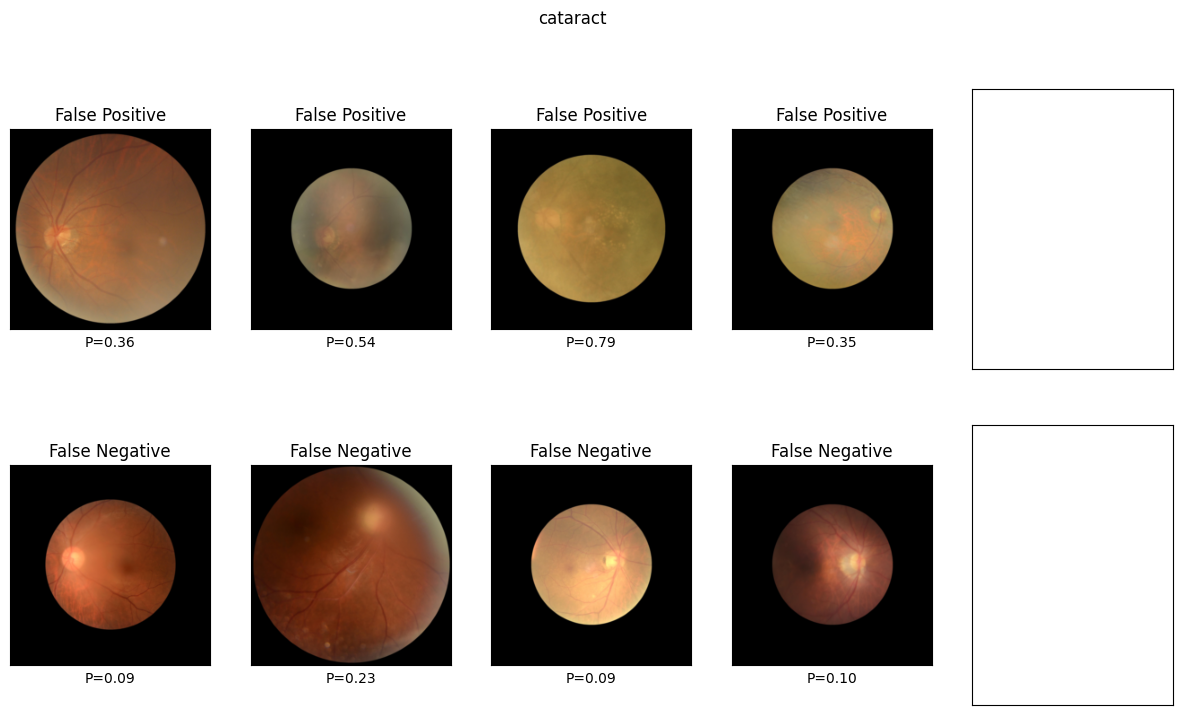

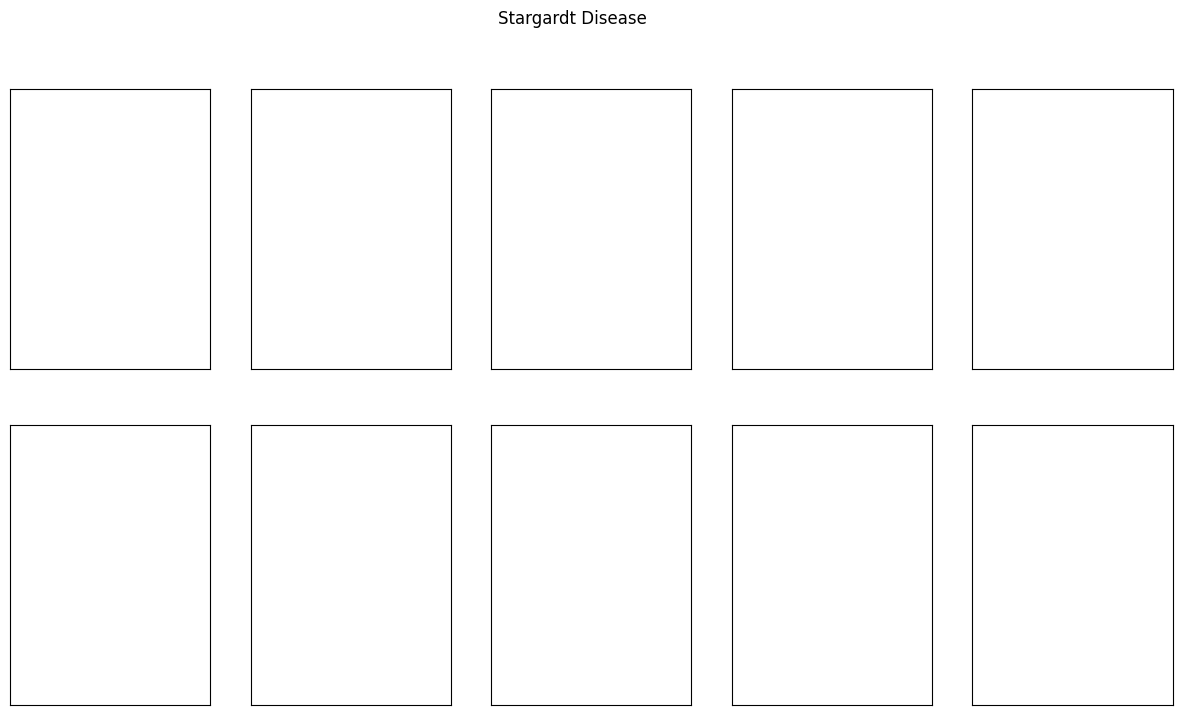

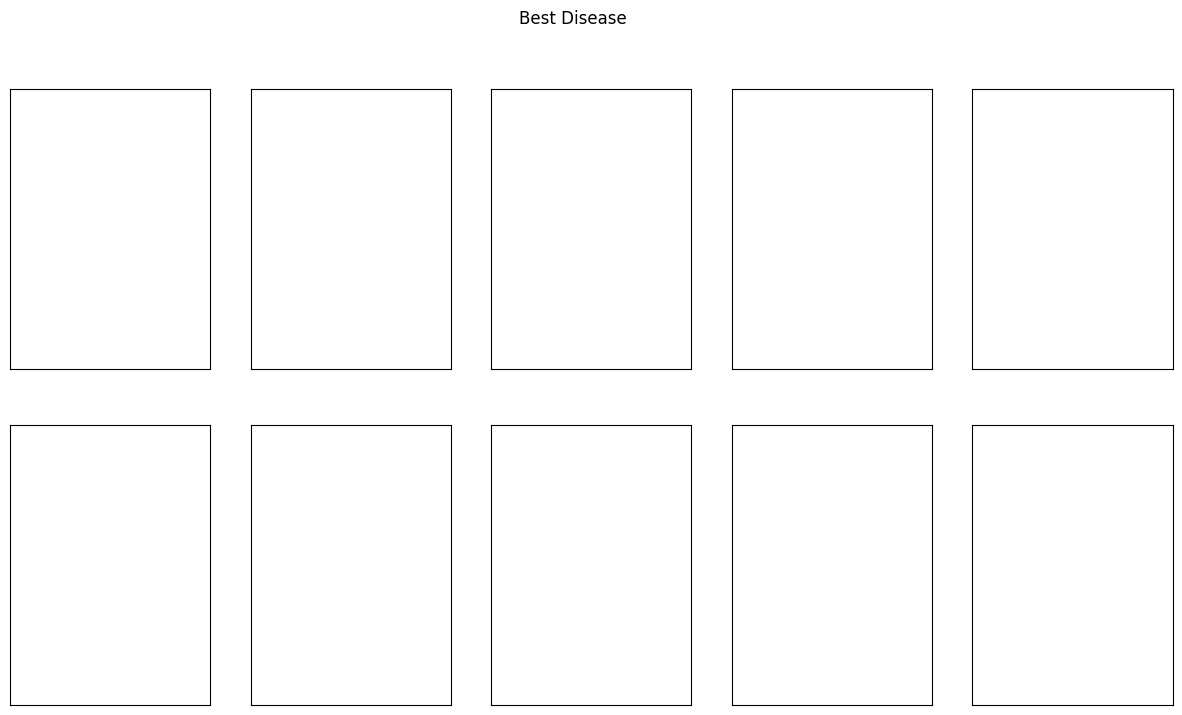

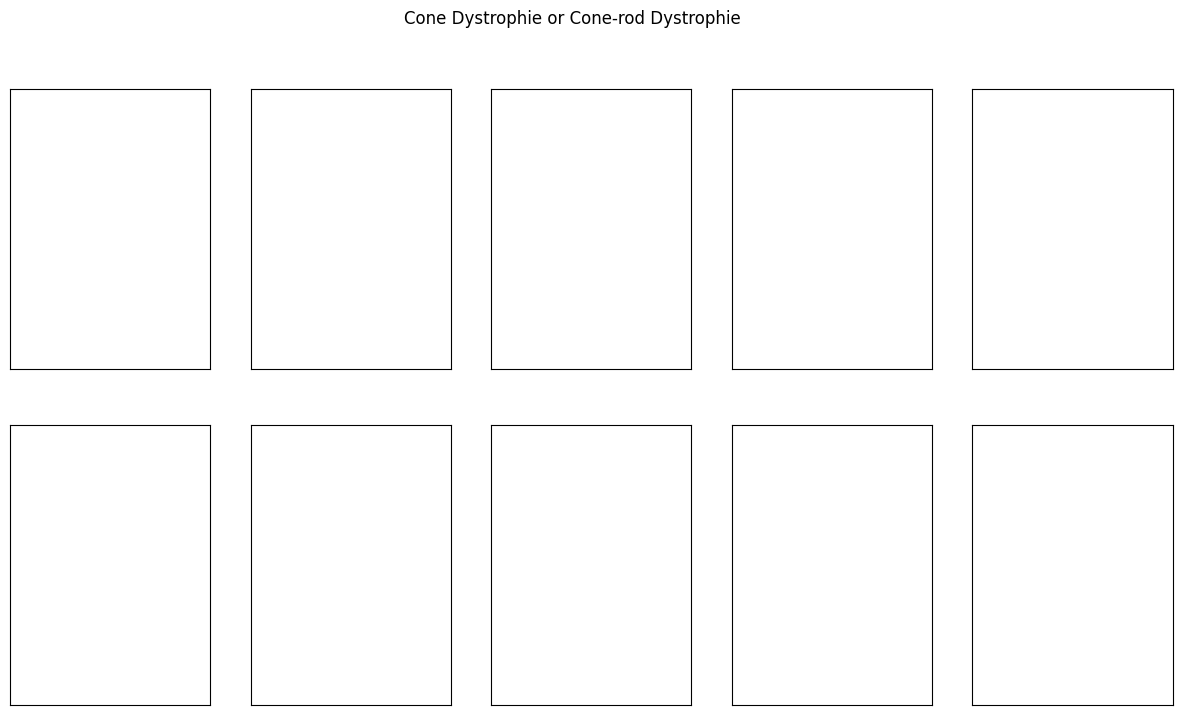

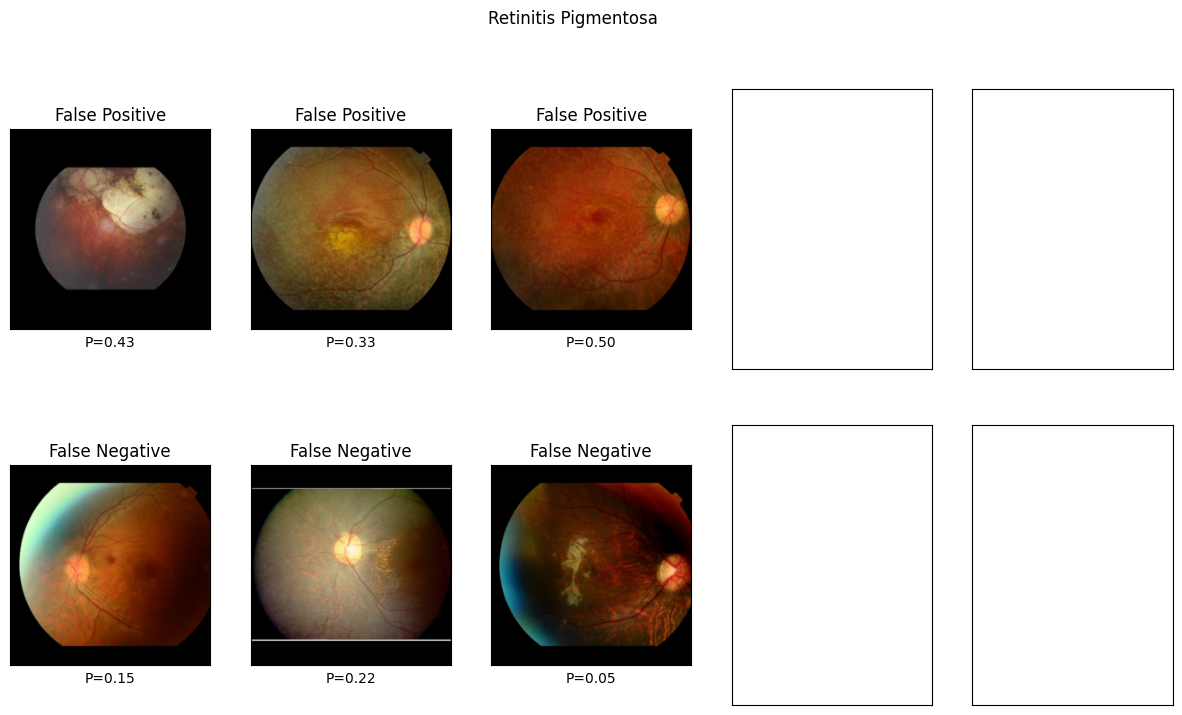

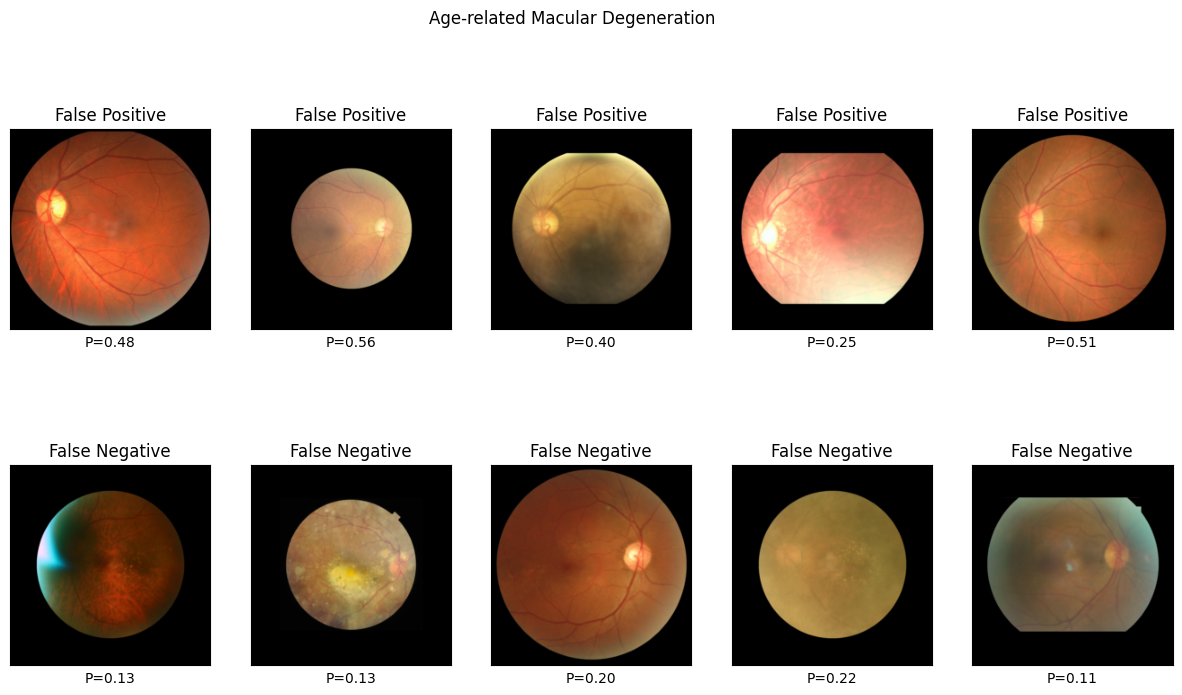

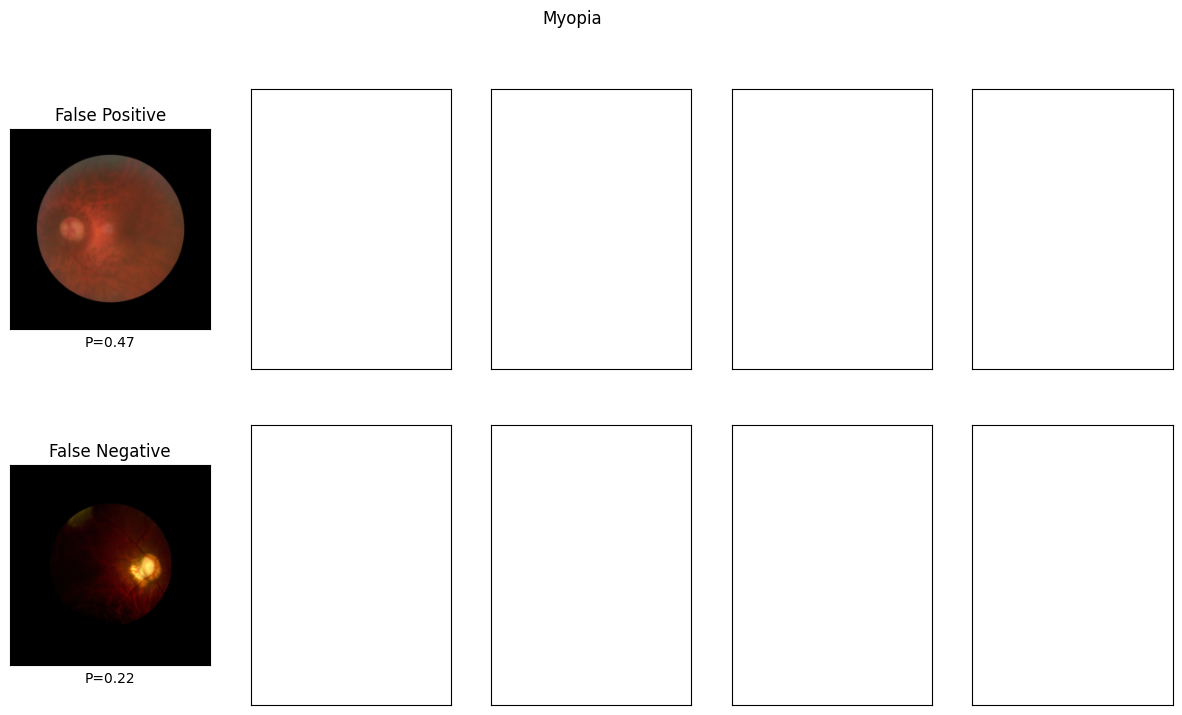

In [91]:
# Replace this with your actual data
all_train_dataset_classes = all_train_dataset.classes
n_categories_per_class = 2
n_images_per_category = 5
y_pred_prob = torch.sigmoid(y_pred)
for i, class_label in enumerate(all_train_dataset_classes):
    #filter the dataset to only images of the current class
    class_indices = torch.where(y_true[:, i] == 1)[0]
    #find the indices of the images which are fp and fn
    fp_indices = torch.where((y_true[:, i] == 0) & (y_pred_cm[:, i] == 1))[0]
    fn_indices = torch.where((y_true[:, i] == 1) & (y_pred_cm[:, i] == 0))[0]
    #get 5 random indices
    fp_indices = fp_indices[torch.randperm(len(fp_indices))[:5]].numpy()
    fn_indices = fn_indices[torch.randperm(len(fn_indices))[:5]].numpy()
    #get the images and labels from the test set
    fp_images = [all_test_dataset[i][0] for i in fp_indices]
    fn_images = [all_test_dataset[i][0] for i in fn_indices]
    #split ax into 5 subplots
    fig, axes = plt.subplots(2, 5, figsize=(15, 8))
    axes = axes.flatten()
    #turn off all axes ticks
    for ax in axes:
        ax.set_xticks([])
        ax.set_yticks([])
    
    #plot the false positives and false negatives
    for j, (fp_image, fn_image) in enumerate(zip(fp_images, fn_images)):
        axes[j].imshow(fp_image.permute(1, 2, 0))
        axes[j].set_title('False Positive')
        axes[j+5].imshow(fn_image.permute(1, 2, 0))
        axes[j+5].set_title('False Negative')
        #add probability of the image being in the class
        axes[j].set_xlabel(f'P={y_pred_prob[fp_indices[j], i]:.2f}')
        axes[j+5].set_xlabel(f'P={y_pred_prob[fn_indices[j], i]:.2f}')
    #set a title for the class
    fig.suptitle(class_label)



#plt.tight_layout()
plt.show()

In [92]:
#show how many tp, fp, tn, fn there are in total
tp = confusion_matrices[:, 1, 1]
fp = confusion_matrices[:, 0, 1]
tn = confusion_matrices[:, 0, 0]
fn = confusion_matrices[:, 1, 0]
print(f'TP: {tp.sum()}')
print(f'FP: {fp.sum()}')
print(f'TN: {tn.sum()}')
print(f'FN: {fn.sum()}')
print('-----------------------------------')
#calculate the precision, recall, accuracy and f1 score
precision = multi_label_precision(y_true, y_pred, threshold=best_threshold, averaging_type='macro')
recall = multi_label_recal(y_true, y_pred, threshold=best_threshold, averaging_type='macro')
accuracy = multi_label_accuracy(y_true, y_pred, threshold=best_threshold, averaging_type='macro')
f1 = multi_label_f_beta(y_true, y_pred, beta=1.0, averaging_type='macro', threshold=best_threshold)
print(f'Precision macro: {precision:.2f}')
print(f'Recall macro: {recall:.2f}')
print(f'Accuracy macro: {accuracy:.2f}')
print(f'F1 macro: {f1:.2f}')
print('-----------------------------------')
#do the same for the micro scores
precision = multi_label_precision(y_true, y_pred, threshold=best_threshold, averaging_type='micro')
recall = multi_label_recal(y_true, y_pred, threshold=best_threshold, averaging_type='micro')
accuracy = multi_label_accuracy(y_true, y_pred, threshold=best_threshold, averaging_type='micro')
f1 = multi_label_f_beta(y_true, y_pred, beta=1.0, averaging_type='micro', threshold=best_threshold)
print(f'Precision micro: {precision:.2f}')
print(f'Recall micro: {recall:.2f}')
print(f'Accuracy micro: {accuracy:.2f}')
print(f'F1 micro: {f1:.2f}')


TP: 288
FP: 110
TN: 3566
FN: 56
-----------------------------------
Precision macro: 0.73
Recall macro: 0.90
Accuracy macro: 0.96
F1 macro: 0.80
-----------------------------------
Precision micro: 0.72
Recall micro: 0.84
Accuracy micro: 0.96
F1 micro: 0.78
